# Step 5: Ethical AI & Bias Auditing

## Import Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import joblib
import json
import warnings
from datetime import datetime
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

os.makedirs('../explainability', exist_ok=True)
os.makedirs('../fairness', exist_ok=True)
os.makedirs('../figures/explainability', exist_ok=True)
os.makedirs('../figures/fairness', exist_ok=True)

## Load data and models

In [35]:
df = pd.read_csv('../data/df_selected_features.csv')
df.head()

,sex,pregnant,query_hyperthyroid,goitre,psych,TSH_measured,TSH,T3_measured,T3,TT4,...,T4U,FTI,T3_T4_ratio,TSH_T4_product,any_treatment,medical_complexity_score,symptom_query_score,target,target_binary,patient_id
0,0,0,0,0,0,1,0.3,0,1.9,104.0,...,0.96,109.0,0.018269,31.2,0,0,1,-,0,840801013
1,0,0,0,0,0,1,1.6,1,1.9,128.0,...,0.96,109.0,0.014844,204.8,0,0,0,-,0,840801014
2,0,0,1,0,0,0,1.4,0,1.9,104.0,...,0.96,109.0,0.018269,145.6,0,0,1,-,0,840801042
3,0,0,0,0,0,0,1.4,0,1.9,104.0,...,0.96,109.0,0.018269,145.6,0,0,0,-,0,840803046
4,0,0,0,0,0,0,1.4,0,1.9,104.0,...,0.96,109.0,0.018269,145.6,0,0,0,S,1,840803047


In [36]:
# Load configuration
with open('../models/config.json', 'r') as f:
    config = json.load(f)
    
best_binary_model = joblib.load('../models/best_binary_model.pkl')
best_multiclass_model = joblib.load('../models/best_multiclass_model.pkl')
scaler_binary = joblib.load('../models/scaler_binary.pkl')
scaler_multiclass = joblib.load('../models/scaler_multiclass.pkl')

print(f"Best Binary Model: {config['best_binary_model']}")
print(f"Best Multi-class Model: {config['best_multiclass_model']}")

Best Binary Model: Gradient Boosting
Best Multi-class Model: Random Forest


In [37]:
feature_columns = config['feature_columns']
X = df[feature_columns]
y_binary = df['target_binary']
y_multiclass = df[df['target_binary'] == 1]['target']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)
X_train_bin_scaled = scaler_binary.transform(X_train_bin)
X_test_bin_scaled = scaler_binary.transform(X_test_bin)

df_sick = df[df['target_binary'] == 1]
X_sick = df_sick[feature_columns]
y_sick = df_sick['target']

class_counts = y_sick.value_counts()

valid_classes = class_counts[class_counts >= 2].index
rare_classes = class_counts[class_counts < 2].index

if len(rare_classes) > 0:
    print(f"Removing {len(rare_classes)} rare classes: {list(rare_classes)}")
    mask = y_sick.isin(valid_classes)
    X_sick = X_sick[mask]
    y_sick = y_sick[mask]

try:
    X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
        X_sick, y_sick, test_size=0.2, random_state=42, stratify=y_sick
    )
except ValueError:
    # Use non-stratified as fallback
    X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
        X_sick, y_sick, test_size=0.2, random_state=42, stratify=None
    )

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_sick, y_sick, test_size=0.2, random_state=RANDOM_STATE, stratify=y_sick
)
X_train_multi_scaled = scaler_multiclass.transform(X_train_multi)
X_test_multi_scaled = scaler_multiclass.transform(X_test_multi)

Removing 5 rare classes: ['LJ', 'GKJ', 'OI', 'D|R', 'E']


## Model Explainability 

### SHAP Analysis

In [38]:
explainer_bin = shap.TreeExplainer(best_binary_model)

sample_size = min(500, len(X_test_bin_scaled))
X_test_sample_bin = X_test_bin_scaled[:sample_size]
shap_values_bin = explainer_bin.shap_values(X_test_sample_bin)

# For binary classification, select the positive class SHAP values
if isinstance(shap_values_bin, list):
    shap_values_bin_plot = shap_values_bin[1]
else:
    shap_values_bin_plot = shap_values_bin

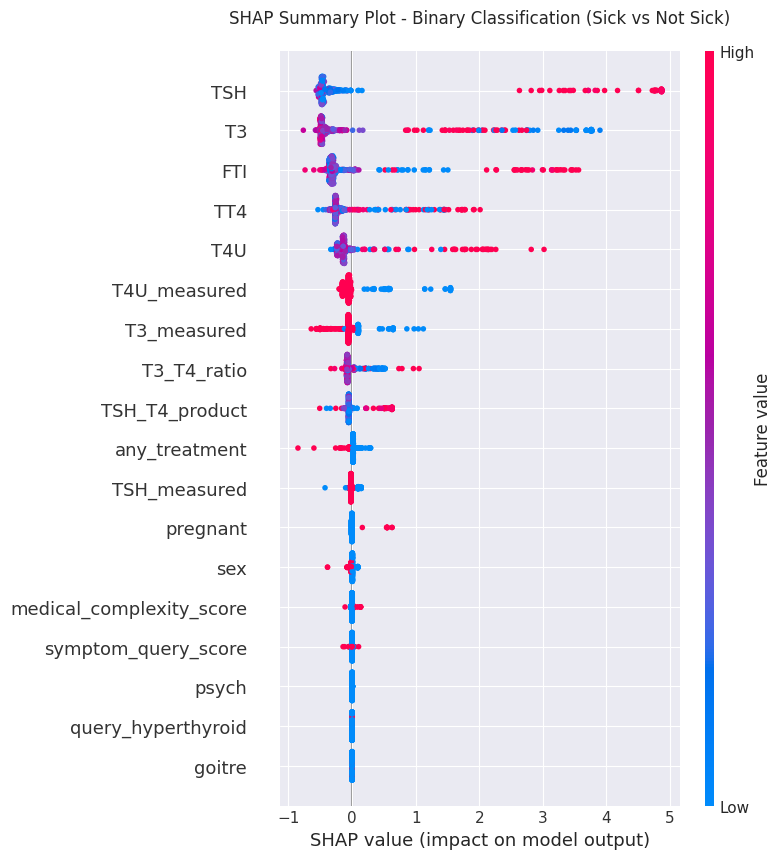

In [39]:
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_bin_plot,
    X_test_sample_bin,
    feature_names=feature_columns,
    show=False,
    max_display=20
)
plt.title('SHAP Summary Plot - Binary Classification (Sick vs Not Sick)', 
          fontsize=12, pad=20)
plt.tight_layout()
plt.savefig('../figures/explainability/shap_summary_binary.png', dpi=300, bbox_inches='tight')
plt.show()

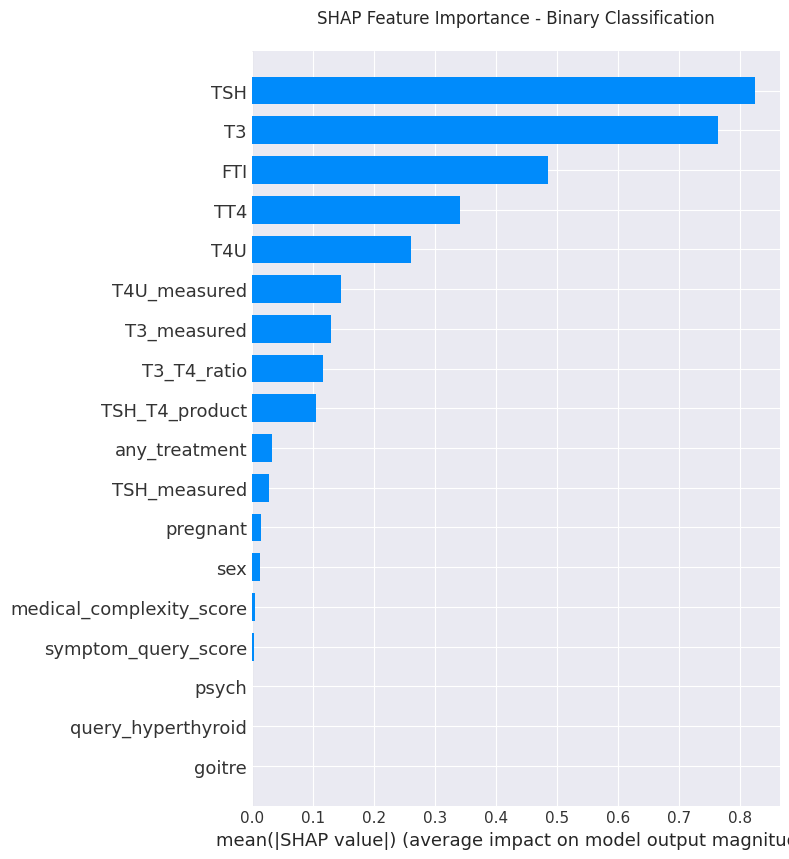

In [40]:
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_bin_plot,
    X_test_sample_bin,
    feature_names=feature_columns,
    plot_type="bar",
    show=False,
    max_display=20
)
plt.title('SHAP Feature Importance - Binary Classification', 
          fontsize=12, pad=20)
plt.tight_layout()
plt.savefig('../figures/explainability/shap_importance_binary.png', dpi=300, bbox_inches='tight')
plt.show()


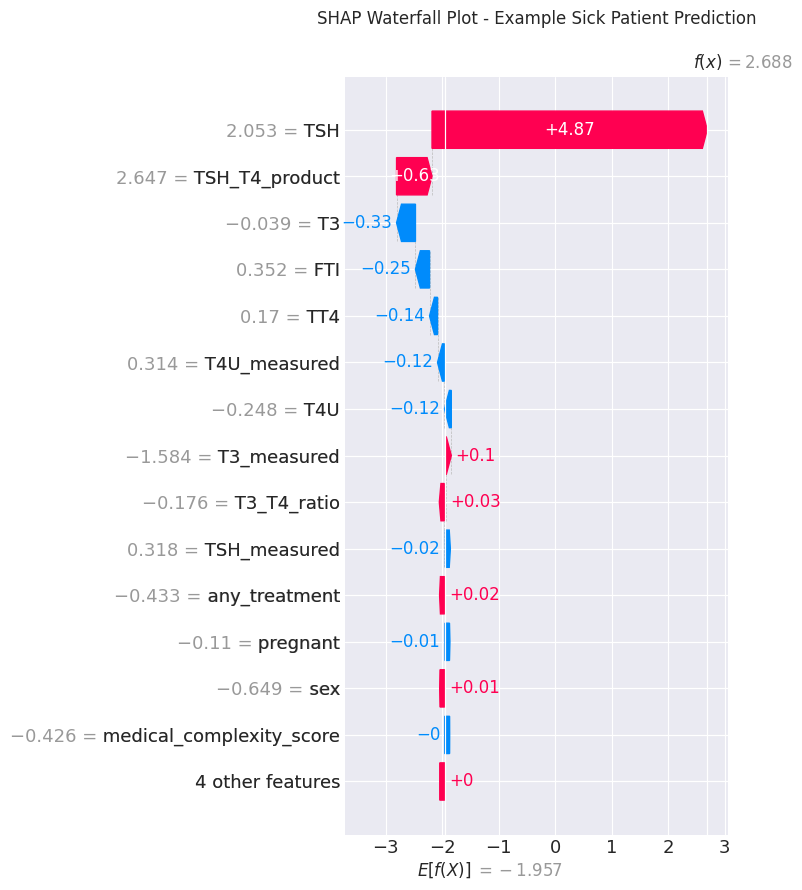

In [41]:
sick_indices = np.where(y_test_bin.values[:sample_size] == 1)[0]
if len(sick_indices) > 0:
    example_idx = sick_indices[0]
    
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_bin_plot[example_idx],
            base_values=explainer_bin.expected_value if not isinstance(explainer_bin.expected_value, list) else explainer_bin.expected_value[1],
            data=X_test_sample_bin[example_idx],
            feature_names=feature_columns
        ),
        show=False,
        max_display=15
    )
    plt.title('SHAP Waterfall Plot - Example Sick Patient Prediction', 
              fontsize=12, pad=20)
    plt.tight_layout()
    plt.savefig('../figures/explainability/shap_waterfall_example.png', dpi=300, bbox_inches='tight')
    plt.show()


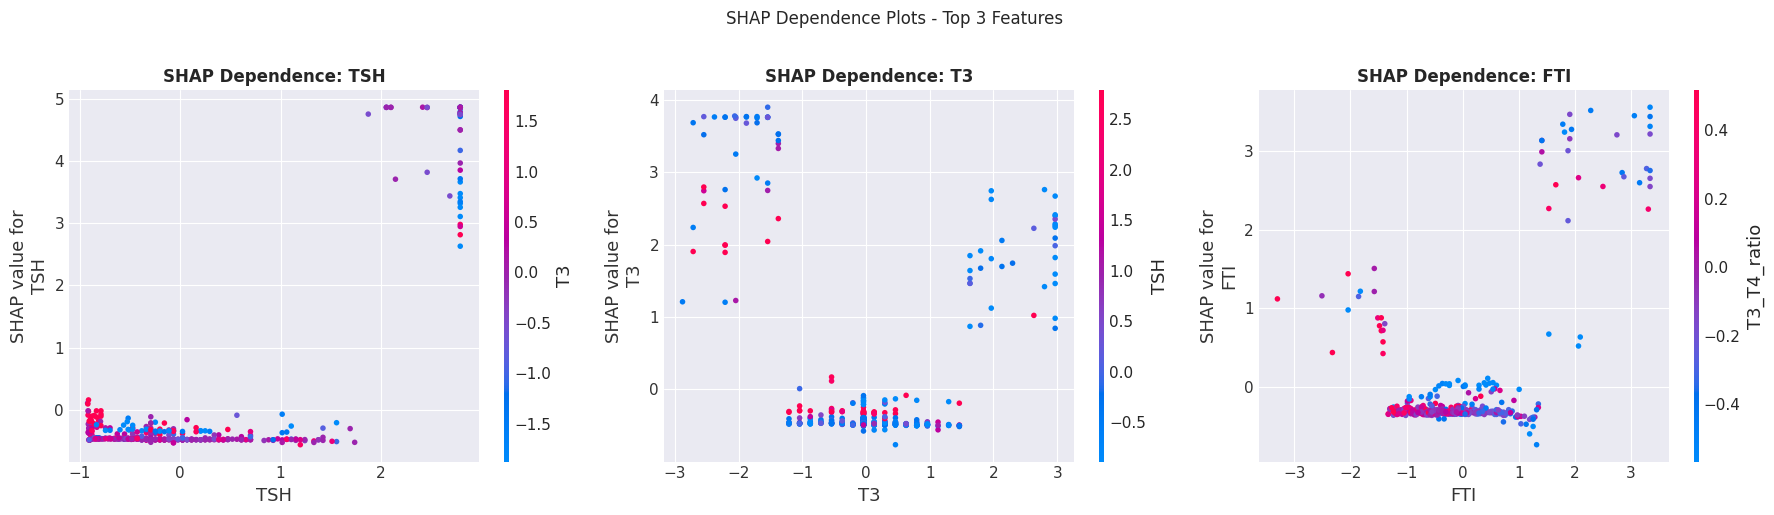

In [42]:
mean_abs_shap = np.abs(shap_values_bin_plot).mean(axis=0)
top_feature_indices = np.argsort(mean_abs_shap)[-3:][::-1]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature_idx in enumerate(top_feature_indices):
    feature_name = feature_columns[feature_idx]
    
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature_idx,
        shap_values_bin_plot,
        X_test_sample_bin,
        feature_names=feature_columns,
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'SHAP Dependence: {feature_name}', fontsize=12, fontweight='bold')

plt.suptitle('SHAP Dependence Plots - Top 3 Features', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig('../figures/explainability/shap_dependence_top3.png', dpi=300, bbox_inches='tight')
plt.show()

### LIME Analysis

In [43]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train_bin_scaled,
    feature_names=feature_columns,
    class_names=['Not Sick', 'Sick'],
    mode='classification',
    random_state=RANDOM_STATE
)

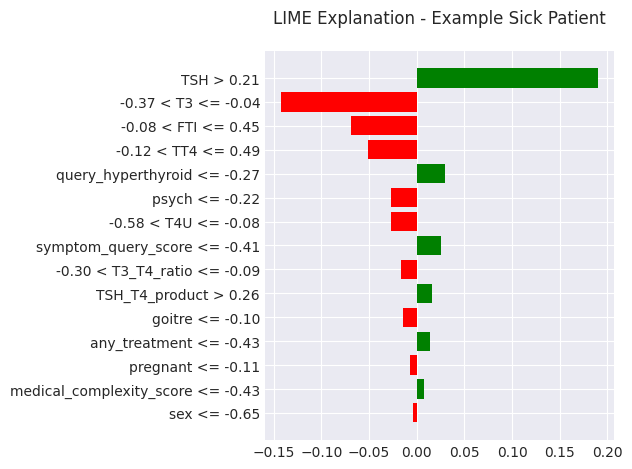


Prediction probabilities: [0.06368946 0.93631054]


In [44]:
sick_test_indices = np.where(y_test_bin.values == 1)[0]
if len(sick_test_indices) > 0:
    example_idx = sick_test_indices[0]
    
    lime_exp = lime_explainer.explain_instance(
        X_test_bin_scaled[example_idx],
        best_binary_model.predict_proba,
        num_features=15
    )
    
    fig = lime_exp.as_pyplot_figure()
    plt.title('LIME Explanation - Example Sick Patient', fontsize=12, pad=20)
    plt.tight_layout()
    plt.savefig('../figures/explainability/lime_explanation_sick.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nPrediction probabilities: {best_binary_model.predict_proba(X_test_bin_scaled[example_idx].reshape(1, -1))[0]}")

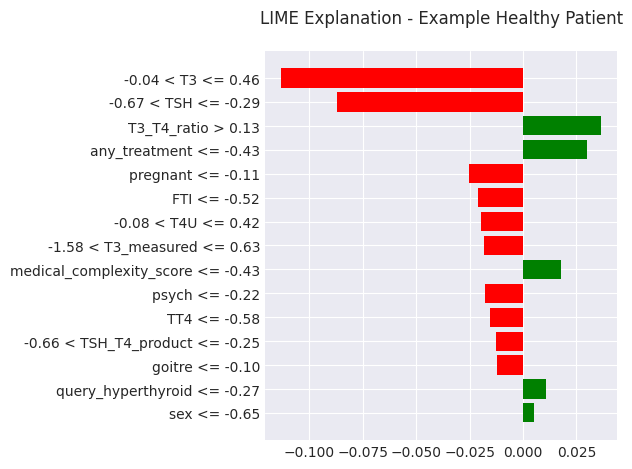


Prediction probabilities: [0.98031587 0.01968413]


In [45]:
healthy_test_indices = np.where(y_test_bin.values == 0)[0]
if len(healthy_test_indices) > 0:
    example_idx = healthy_test_indices[0]
    
    lime_exp = lime_explainer.explain_instance(
        X_test_bin_scaled[example_idx],
        best_binary_model.predict_proba,
        num_features=15
    )
    
    fig = lime_exp.as_pyplot_figure()
    plt.title('LIME Explanation - Example Healthy Patient', fontsize=12, pad=20)
    plt.tight_layout()
    plt.savefig('../figures/explainability/lime_explanation_healthy.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nPrediction probabilities: {best_binary_model.predict_proba(X_test_bin_scaled[example_idx].reshape(1, -1))[0]}")

## Permutation Feature Importance

In [46]:
perm_importance = permutation_importance(
    best_binary_model,
    X_test_bin_scaled,
    y_test_bin,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

perm_imp_df = pd.DataFrame({
    'feature': feature_columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nTop 10 Features by Permutation Importance:")
print(perm_imp_df.head(10))


Top 10 Features by Permutation Importance:
                feature  importance_mean  importance_std
6                   TSH         0.128174        0.004331
8                    T3         0.091553        0.004977
12                  FTI         0.065014        0.003846
11                  T4U         0.036022        0.002888
9                   TT4         0.019128        0.002919
7           T3_measured         0.010191        0.002248
15        any_treatment         0.002779        0.000860
10         T4U_measured         0.002452        0.000920
13          T3_T4_ratio         0.002125        0.001388
17  symptom_query_score         0.000327        0.000361


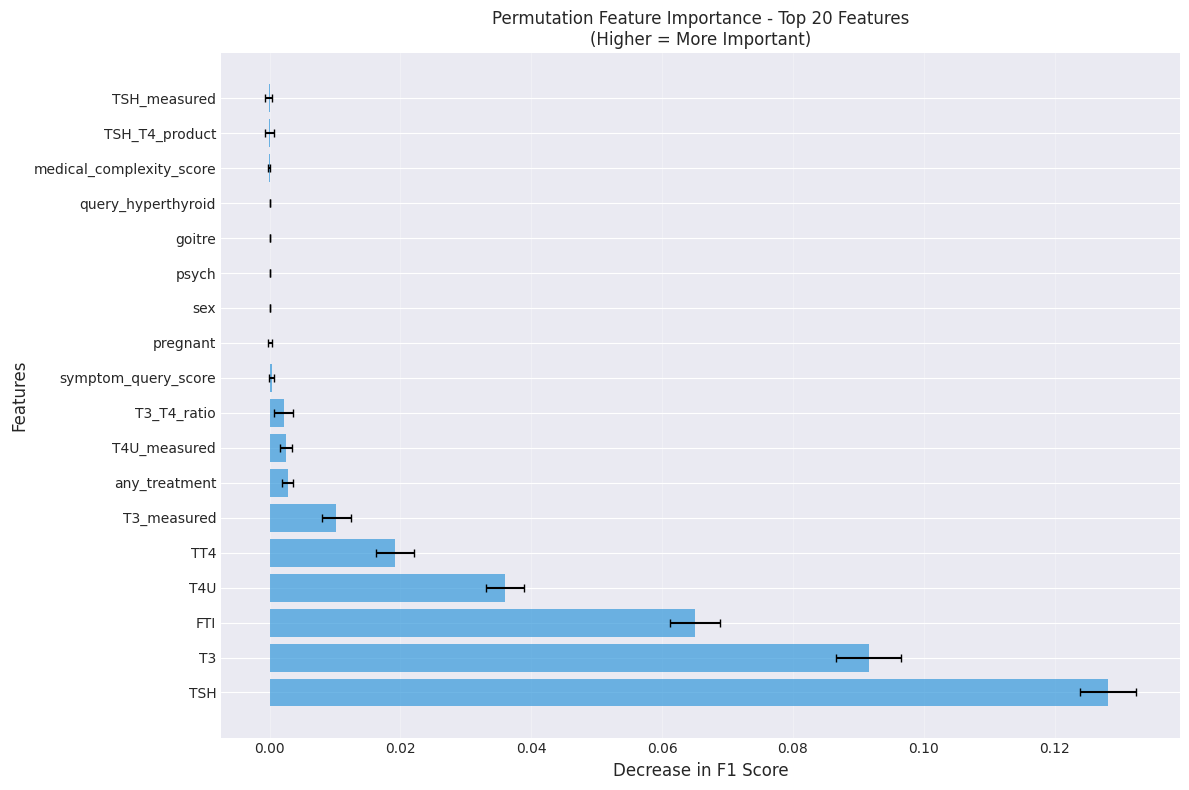

In [47]:
plt.figure(figsize=(12, 8))

top_20 = perm_imp_df.head(20)
plt.barh(range(len(top_20)), top_20['importance_mean'], 
         xerr=top_20['importance_std'], color='#3498db', alpha=0.7, capsize=3)
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Decrease in F1 Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Permutation Feature Importance - Top 20 Features\n(Higher = More Important)', 
          fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/explainability/permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Limitations Analysis

### Class Imbalance Analysis

In [48]:
binary_counts = df['target_binary'].value_counts()
binary_ratio = binary_counts[0] / binary_counts[1]

print("Binary Classification:")
print(f"Not Sick: {binary_counts[0]:,} ({binary_counts[0]/len(df)*100:.2f}%)")
print(f"Sick: {binary_counts[1]:,} ({binary_counts[1]/len(df)*100:.2f}%)")
print(f"Imbalance Ratio: {binary_ratio:.2f}:1")

Binary Classification:
Not Sick: 6,771 (73.82%)
Sick: 2,401 (26.18%)
Imbalance Ratio: 2.82:1


In [49]:
multiclass_counts = df[df['target_binary'] == 1]['target'].value_counts()
print("\Multi-class Distribution (Among Sick Patients):")
for cls, count in multiclass_counts.items():
    print(f"{cls}: {count:,} ({count/len(df_sick)*100:.2f}%)")

median_count = multiclass_counts.median()
severe_imbalance = multiclass_counts[multiclass_counts < median_count / 2]

print(f"Severely underrepresented classes (< 50% of median):")
for cls, count in severe_imbalance.items():
    print(f"{cls}: {count} samples")

\Multi-class Distribution (Among Sick Patients):
K: 436 (18.16%)
G: 359 (14.95%)
I: 346 (14.41%)
F: 233 (9.70%)
R: 196 (8.16%)
A: 147 (6.12%)
L: 115 (4.79%)
M: 111 (4.62%)
N: 110 (4.58%)
S: 85 (3.54%)
GK: 49 (2.04%)
AK: 46 (1.92%)
J: 30 (1.25%)
B: 21 (0.87%)
MK: 16 (0.67%)
O: 14 (0.58%)
Q: 14 (0.58%)
C|I: 12 (0.50%)
KJ: 11 (0.46%)
GI: 10 (0.42%)
H|K: 8 (0.33%)
D: 8 (0.33%)
FK: 6 (0.25%)
C: 6 (0.25%)
P: 5 (0.21%)
MI: 2 (0.08%)
LJ: 1 (0.04%)
GKJ: 1 (0.04%)
OI: 1 (0.04%)
D|R: 1 (0.04%)
E: 1 (0.04%)
Severely underrepresented classes (< 50% of median):
FK: 6 samples
C: 6 samples
P: 5 samples
MI: 2 samples
LJ: 1 samples
GKJ: 1 samples
OI: 1 samples
D|R: 1 samples
E: 1 samples


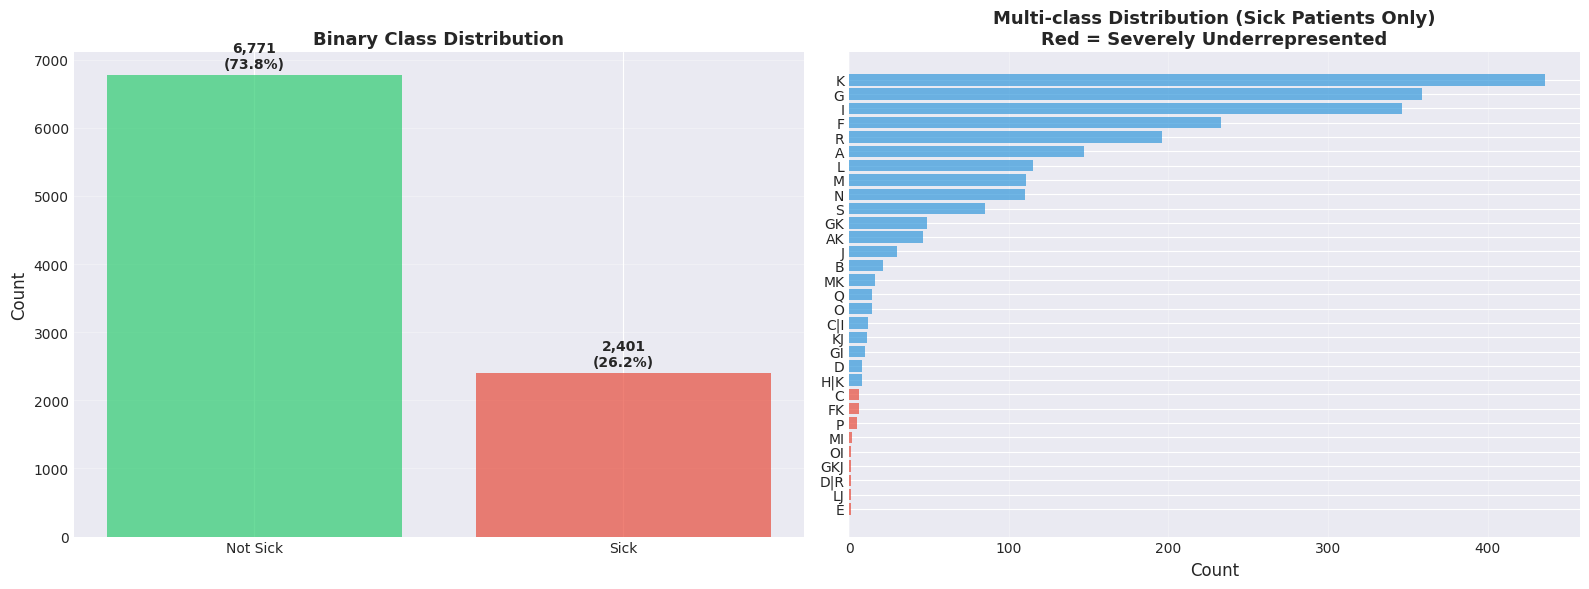

In [50]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary distribution
axes[0].bar(['Not Sick', 'Sick'], binary_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Binary Class Distribution', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(binary_counts.values):
    axes[0].text(i, v + 100, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', fontweight='bold')

# Multi-class distribution
multiclass_counts_sorted = multiclass_counts.sort_values(ascending=True)
colors = ['#e74c3c' if count in severe_imbalance.values else '#3498db' 
          for count in multiclass_counts_sorted.values]
axes[1].barh(range(len(multiclass_counts_sorted)), multiclass_counts_sorted.values, 
             color=colors, alpha=0.7)
axes[1].set_yticks(range(len(multiclass_counts_sorted)))
axes[1].set_yticklabels(multiclass_counts_sorted.index)
axes[1].set_xlabel('Count', fontsize=12)
axes[1].set_title('Multi-class Distribution (Sick Patients Only)\nRed = Severely Underrepresented', 
                  fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/fairness/class_imbalance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Data Leakage Check

In [51]:
# Check for potential data leakage
# Check correlation between features and target
correlations_bin = df[feature_columns + ['target_binary']].corr()['target_binary'].drop('target_binary')
high_corr_features = correlations_bin[abs(correlations_bin) > 0.8]

print("1. Features with suspiciously high correlation (>0.8) with target:")
if len(high_corr_features) > 0:
    for feat, corr in high_corr_features.items():
        print(f"{feat}: {corr:.3f}")
    print("These features may indicate data leakage")
else:
    print("No features with suspiciously high correlation")

1. Features with suspiciously high correlation (>0.8) with target:
No features with suspiciously high correlation


In [52]:
# Check for target-derived features
print("\n2. Checking for potential target-derived features:")
suspicious_keywords = ['target', 'diagnosis', 'outcome', 'result', 'label', 'class']
suspicious_features = [feat for feat in feature_columns 
                       if any(keyword in feat.lower() for keyword in suspicious_keywords)]

if suspicious_features:
    print("Features with suspicious naming:")
    for feat in suspicious_features:
        print(f"- {feat}")
else:
    print("No suspicious feature names detected")


2. Checking for potential target-derived features:
No suspicious feature names detected


In [53]:
# Check for perfect predictions
print("\n3. Checking for features that perfectly predict the target:")
perfect_predictors = []
for feat in feature_columns:
    unique_vals_per_class = df.groupby('target_binary')[feat].nunique()
    if (unique_vals_per_class == 1).all():
        perfect_predictors.append(feat)

if perfect_predictors:
    print("Features that perfectly separate classes:")
    for feat in perfect_predictors:
        print(f"- {feat}")
else:
    print("No perfect predictors found")



3. Checking for features that perfectly predict the target:
No perfect predictors found


### Overfitting Assessment

In [54]:
# Assess overfitting by comparing train vs test performance
# Binary model performance
y_train_pred_bin = best_binary_model.predict(X_train_bin_scaled)
y_test_pred_bin = best_binary_model.predict(X_test_bin_scaled)

train_acc_bin = accuracy_score(y_train_bin, y_train_pred_bin)
test_acc_bin = accuracy_score(y_test_bin, y_test_pred_bin)
train_f1_bin = f1_score(y_train_bin, y_train_pred_bin)
test_f1_bin = f1_score(y_test_bin, y_test_pred_bin)

print("Binary Classification Model:")
print(f"Training Accuracy: {train_acc_bin:.4f}")
print(f"Test Accuracy: {test_acc_bin:.4f}")
print(f"Accuracy Gap: {train_acc_bin - test_acc_bin:.4f}")
print(f"\nTraining F1: {train_f1_bin:.4f}")
print(f"Test F1: {test_f1_bin:.4f}")
print(f"F1 Gap: {train_f1_bin - test_f1_bin:.4f}")

if train_acc_bin - test_acc_bin > 0.1:
    print("Overfitting detected (gap > 10%)")
elif train_acc_bin - test_acc_bin > 0.05:
    print("Moderate overfitting detected (gap > 5%)")
else:
    print("Acceptable generalization (gap < 5%)")

Binary Classification Model:
Training Accuracy: 0.9509
Test Accuracy: 0.9439
Accuracy Gap: 0.0071

Training F1: 0.9056
Test F1: 0.8926
F1 Gap: 0.0130
Acceptable generalization (gap < 5%)


In [55]:
# Multi-class model performance
y_train_pred_multi = best_multiclass_model.predict(X_train_multi_scaled)
y_test_pred_multi = best_multiclass_model.predict(X_test_multi_scaled)

train_acc_multi = accuracy_score(y_train_multi, y_train_pred_multi)
test_acc_multi = accuracy_score(y_test_multi, y_test_pred_multi)
train_f1_multi = f1_score(y_train_multi, y_train_pred_multi, average='weighted')
test_f1_multi = f1_score(y_test_multi, y_test_pred_multi, average='weighted')

print("\n\nMulti-class Classification Model:")
print(f"Training Accuracy: {train_acc_multi:.4f}")
print(f"Test Accuracy: {test_acc_multi:.4f}")
print(f"Accuracy Gap: {train_acc_multi - test_acc_multi:.4f}")
print(f"\nTraining F1 (Weighted): {train_f1_multi:.4f}")
print(f"Test F1 (Weighted): {test_f1_multi:.4f}")
print(f"F1 Gap: {train_f1_multi - test_f1_multi:.4f}")

if train_acc_multi - test_acc_multi > 0.1:
    print("Overfitting detected (gap > 10%)")
elif train_acc_multi - test_acc_multi > 0.05:
    print("Moderate overfitting detected (gap > 5%)")
else:
    print("Acceptable generalization (gap < 5%)")



Multi-class Classification Model:
Training Accuracy: 0.9629
Test Accuracy: 0.9146
Accuracy Gap: 0.0484

Training F1 (Weighted): 0.9554
Test F1 (Weighted): 0.9067
F1 Gap: 0.0487
Acceptable generalization (gap < 5%)


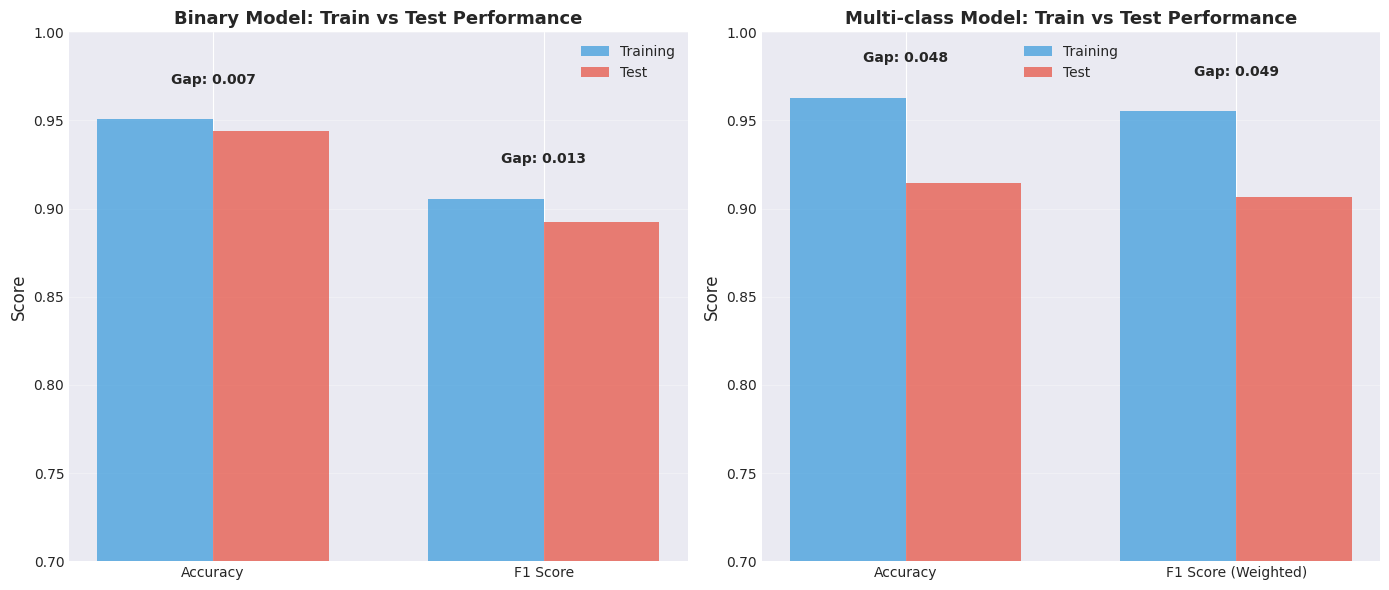

In [56]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Binary model
metrics_bin = ['Accuracy', 'F1 Score']
train_scores_bin = [train_acc_bin, train_f1_bin]
test_scores_bin = [test_acc_bin, test_f1_bin]

x = np.arange(len(metrics_bin))
width = 0.35

axes[0].bar(x - width/2, train_scores_bin, width, label='Training', color='#3498db', alpha=0.7)
axes[0].bar(x + width/2, test_scores_bin, width, label='Test', color='#e74c3c', alpha=0.7)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Binary Model: Train vs Test Performance', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_bin)
axes[0].legend()
axes[0].set_ylim([0.7, 1.0])
axes[0].grid(axis='y', alpha=0.3)

for i, (train, test) in enumerate(zip(train_scores_bin, test_scores_bin)):
    gap = train - test
    axes[0].text(i, max(train, test) + 0.02, f'Gap: {gap:.3f}', 
                 ha='center', fontsize=10, fontweight='bold')

# Multi-class model
metrics_multi = ['Accuracy', 'F1 Score (Weighted)']
train_scores_multi = [train_acc_multi, train_f1_multi]
test_scores_multi = [test_acc_multi, test_f1_multi]

x = np.arange(len(metrics_multi))

axes[1].bar(x - width/2, train_scores_multi, width, label='Training', color='#3498db', alpha=0.7)
axes[1].bar(x + width/2, test_scores_multi, width, label='Test', color='#e74c3c', alpha=0.7)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Multi-class Model: Train vs Test Performance', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_multi)
axes[1].legend()
axes[1].set_ylim([0.7, 1.0])
axes[1].grid(axis='y', alpha=0.3)

for i, (train, test) in enumerate(zip(train_scores_multi, test_scores_multi)):
    gap = train - test
    axes[1].text(i, max(train, test) + 0.02, f'Gap: {gap:.3f}', 
                 ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/fairness/overfitting_assessment.png', dpi=300, bbox_inches='tight')
plt.show()

## Bias Detection & Fairness Auditing

### Define Sensitive Attributes

In [57]:
# Define sensitive attributes
sensitive_attrs = {
    'sex': 'Gender',
}

if 'age' in df.columns:
    df['age_group'] = pd.cut(
        df['age'],
        bins=[0, 18, 35, 50, 65, 100],
        labels=['<18', '18-35', '36-50', '51-65', '>65']
    )
    sensitive_attrs['age_group'] = 'Age Group'
    print("\nAge groups created:")
    print(df['age_group'].value_counts().sort_index())
else:
    print("\nAge information not available in dataset")

# Sex distribution
if 'sex' in df.columns:
    print("\nGender distribution:")
    print(df['sex'].value_counts())
    print(f"  0 = Female, 1 = Male")

print(f"Available sensitive attributes: {list(sensitive_attrs.keys())}")


Age information not available in dataset

Gender distribution:
sex
0    6380
1    2792
Name: count, dtype: int64
  0 = Female, 1 = Male
Available sensitive attributes: ['sex']


### Demographic Parity

In [58]:
# Prepare test data with predictions
test_df_bin = X_test_bin.copy()
test_df_bin['true_label'] = y_test_bin.values
test_df_bin['predicted'] = y_test_pred_bin

demographic_parity_results = {}

for attr, attr_name in sensitive_attrs.items():
    if attr in df.columns:
        # Add sensitive attribute to test data
        test_df_bin[attr] = df.loc[test_df_bin.index, attr].values
        
        print(f"\n{attr_name} ({attr}):")
        print("-" * 40)
        
        # Calculate positive prediction rate per group
        group_stats = test_df_bin.groupby(attr).agg({
            'predicted': ['sum', 'count', 'mean']
        })
        
        group_stats.columns = ['positive_preds', 'total', 'positive_rate']
        
        print(group_stats)
        
        # Calculate disparity
        max_rate = group_stats['positive_rate'].max()
        min_rate = group_stats['positive_rate'].min()
        disparity_ratio = min_rate / max_rate if max_rate > 0 else 0
        
        print(f"\nDemographic Parity Ratio: {disparity_ratio:.3f}")
        print(f"(Closer to 1.0 = More fair, <0.8 = Concerning)")
        
        if disparity_ratio < 0.8:
            print("Significant disparity detected (4/5ths rule violated)")
        else:
            print("Acceptable demographic parity")
        
        demographic_parity_results[attr] = {
            'group_stats': group_stats,
            'disparity_ratio': disparity_ratio
        }


Gender (sex):
----------------------------------------
     positive_preds  total  positive_rate
sex                                      
0               356   1237       0.287793
1               123    598       0.205686

Demographic Parity Ratio: 0.715
(Closer to 1.0 = More fair, <0.8 = Concerning)
Significant disparity detected (4/5ths rule violated)


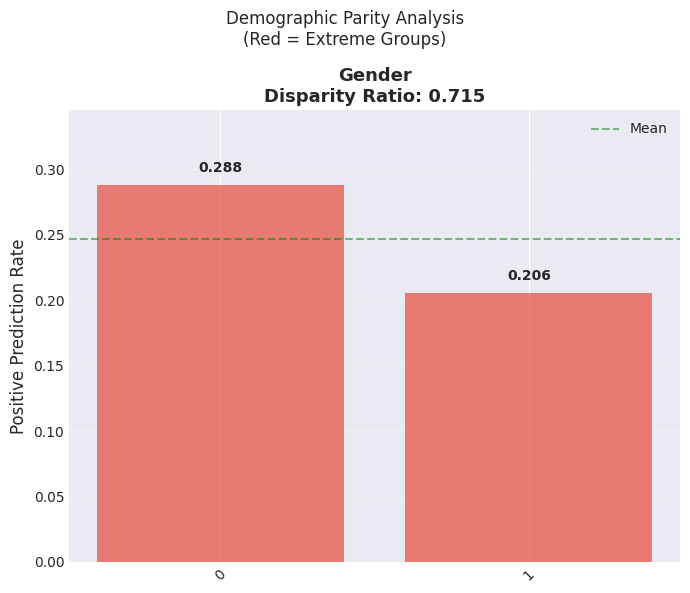

In [59]:
# Visualize Demographic Parity
n_attrs = len(demographic_parity_results)
if n_attrs > 0:
    fig, axes = plt.subplots(1, n_attrs, figsize=(7*n_attrs, 6))
    if n_attrs == 1:
        axes = [axes]
    
    for idx, (attr, results) in enumerate(demographic_parity_results.items()):
        group_stats = results['group_stats']
        disparity_ratio = results['disparity_ratio']
        
        colors = ['#e74c3c' if rate == group_stats['positive_rate'].min() or 
                            rate == group_stats['positive_rate'].max() 
                  else '#3498db' for rate in group_stats['positive_rate']]
        
        axes[idx].bar(range(len(group_stats)), group_stats['positive_rate'], 
                      color=colors, alpha=0.7)
        axes[idx].set_xticks(range(len(group_stats)))
        axes[idx].set_xticklabels(group_stats.index, rotation=45)
        axes[idx].set_ylabel('Positive Prediction Rate', fontsize=12)
        axes[idx].set_title(f'{sensitive_attrs[attr]}\nDisparity Ratio: {disparity_ratio:.3f}', 
                           fontsize=13, fontweight='bold')
        axes[idx].set_ylim([0, max(group_stats['positive_rate']) * 1.2])
        axes[idx].grid(axis='y', alpha=0.3)
        
        for i, v in enumerate(group_stats['positive_rate']):
            axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
        
        axes[idx].axhline(y=group_stats['positive_rate'].mean(), 
                         color='green', linestyle='--', alpha=0.5, label='Mean')
        axes[idx].legend()
    
    plt.suptitle('Demographic Parity Analysis\n(Red = Extreme Groups)', 
                 fontsize=12)
    plt.tight_layout()
    plt.savefig('../figures/fairness/demographic_parity.png', dpi=300, bbox_inches='tight')
    plt.show()

### Equalized Odds

In [60]:
equalized_odds_results = {}

for attr, attr_name in sensitive_attrs.items():
    if attr in test_df_bin.columns:
        print(f"\n{attr_name} ({attr}):")
        print("-" * 40)
        
        group_fairness = []
        
        for group_val in test_df_bin[attr].unique():
            group_mask = test_df_bin[attr] == group_val
            group_data = test_df_bin[group_mask]
            
            # Calculate TPR (True Positive Rate)
            tp = ((group_data['true_label'] == 1) & (group_data['predicted'] == 1)).sum()
            fn = ((group_data['true_label'] == 1) & (group_data['predicted'] == 0)).sum()
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            # Calculate FPR (False Positive Rate)
            fp = ((group_data['true_label'] == 0) & (group_data['predicted'] == 1)).sum()
            tn = ((group_data['true_label'] == 0) & (group_data['predicted'] == 0)).sum()
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            # Calculate TNR (True Negative Rate)
            tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            group_fairness.append({
                'Group': group_val,
                'TPR': tpr,
                'FPR': fpr,
                'TNR': tnr,
                'Sample_Size': len(group_data)
            })
        
        fairness_df = pd.DataFrame(group_fairness)
        print(fairness_df.to_string(index=False))
        
        # Calculate disparities
        tpr_disparity = fairness_df['TPR'].max() - fairness_df['TPR'].min()
        fpr_disparity = fairness_df['FPR'].max() - fairness_df['FPR'].min()
        
        print(f"\nTPR Disparity: {tpr_disparity:.3f}")
        print(f"FPR Disparity: {fpr_disparity:.3f}")
        print(f"(Closer to 0 = More fair, >0.1 = Concerning)")
        
        if tpr_disparity > 0.1 or fpr_disparity > 0.1:
            print("Significant equalized odds violation")
        else:
            print("Acceptable equalized odds")
        
        equalized_odds_results[attr] = {
            'fairness_df': fairness_df,
            'tpr_disparity': tpr_disparity,
            'fpr_disparity': fpr_disparity
        }


Gender (sex):
----------------------------------------
 Group      TPR      FPR      TNR  Sample_Size
     0 0.882353 0.046591 0.953409         1237
     1 0.918699 0.021053 0.978947          598

TPR Disparity: 0.036
FPR Disparity: 0.026
(Closer to 0 = More fair, >0.1 = Concerning)
Acceptable equalized odds


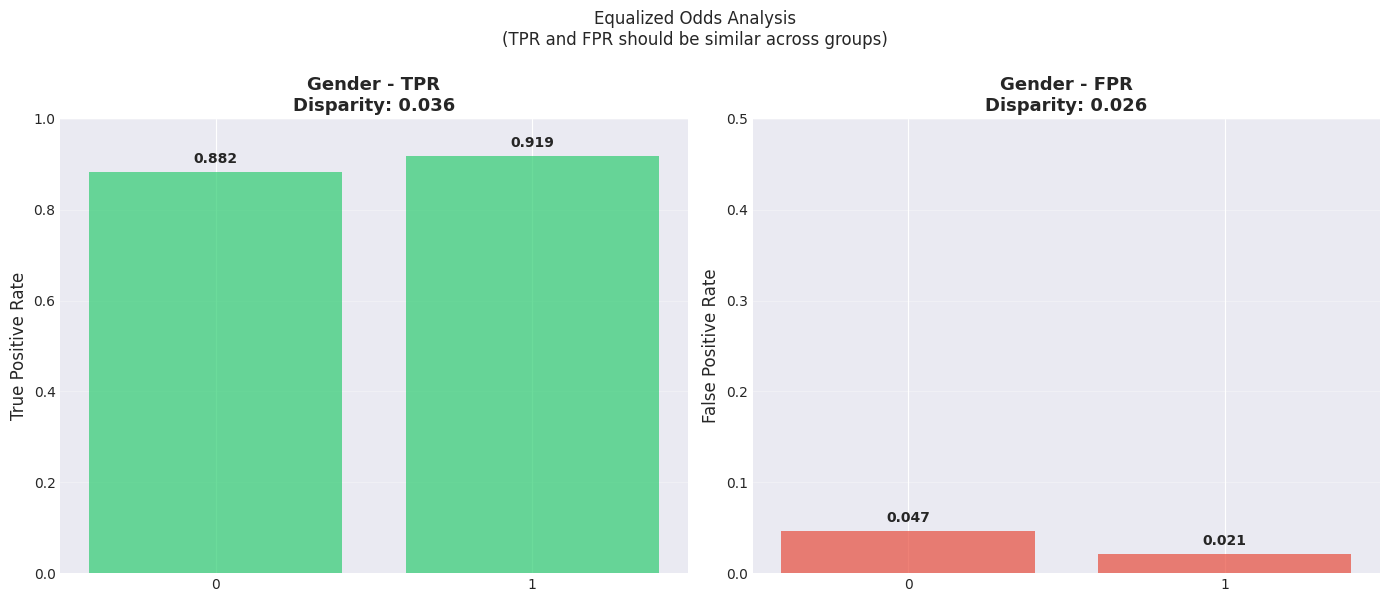

In [61]:
# Visualize Equalized Odds
n_attrs = len(equalized_odds_results)
if n_attrs > 0:
    fig, axes = plt.subplots(n_attrs, 2, figsize=(14, 6*n_attrs))
    if n_attrs == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (attr, results) in enumerate(equalized_odds_results.items()):
        fairness_df = results['fairness_df']
        
        # TPR Plot
        axes[idx, 0].bar(range(len(fairness_df)), fairness_df['TPR'], 
                         color='#2ecc71', alpha=0.7)
        axes[idx, 0].set_xticks(range(len(fairness_df)))
        axes[idx, 0].set_xticklabels(fairness_df['Group'])
        axes[idx, 0].set_ylabel('True Positive Rate', fontsize=12)
        axes[idx, 0].set_title(f'{sensitive_attrs[attr]} - TPR\nDisparity: {results["tpr_disparity"]:.3f}', 
                              fontsize=13, fontweight='bold')
        axes[idx, 0].set_ylim([0, 1])
        axes[idx, 0].grid(axis='y', alpha=0.3)
        
        for i, v in enumerate(fairness_df['TPR']):
            axes[idx, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
        
        # FPR Plot
        axes[idx, 1].bar(range(len(fairness_df)), fairness_df['FPR'], 
                         color='#e74c3c', alpha=0.7)
        axes[idx, 1].set_xticks(range(len(fairness_df)))
        axes[idx, 1].set_xticklabels(fairness_df['Group'])
        axes[idx, 1].set_ylabel('False Positive Rate', fontsize=12)
        axes[idx, 1].set_title(f'{sensitive_attrs[attr]} - FPR\nDisparity: {results["fpr_disparity"]:.3f}', 
                              fontsize=13, fontweight='bold')
        axes[idx, 1].set_ylim([0, max(0.5, fairness_df['FPR'].max() * 1.2)])
        axes[idx, 1].grid(axis='y', alpha=0.3)
        
        for i, v in enumerate(fairness_df['FPR']):
            axes[idx, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
    
    plt.suptitle('Equalized Odds Analysis\n(TPR and FPR should be similar across groups)', 
                 fontsize=12, y=0.995)
    plt.tight_layout()
    plt.savefig('../figures/fairness/equalized_odds.png', dpi=300, bbox_inches='tight')
    plt.show()


### Disparate Impact (4/5ths Rule)

In [62]:
disparate_impact_results = {}

for attr, attr_name in sensitive_attrs.items():
    if attr in test_df_bin.columns:
        print(f"\n{attr_name} ({attr}):")
        print("-" * 40)
        
        # Calculate selection rates per group
        group_rates = test_df_bin.groupby(attr)['predicted'].agg(['sum', 'count', 'mean'])
        group_rates.columns = ['positive_preds', 'total', 'selection_rate']
        
        print(group_rates)
        
        # Calculate disparate impact ratio
        max_rate = group_rates['selection_rate'].max()
        min_rate = group_rates['selection_rate'].min()
        di_ratio = min_rate / max_rate if max_rate > 0 else 0
        
        print(f"\nDisparate Impact Ratio: {di_ratio:.3f}")
        print(f"4/5ths Rule Threshold: 0.800")
        
        if di_ratio < 0.8:
            print(f"Disparate impact detected (ratio < 0.8)")
            
            disadvantaged = group_rates[group_rates['selection_rate'] == min_rate].index.tolist()
            advantaged = group_rates[group_rates['selection_rate'] == max_rate].index.tolist()
            print(f"Disadvantaged group(s): {disadvantaged}")
            print(f"Advantaged group(s): {advantaged}")
        else:
            print(f"No disparate impact (ratio >= 0.8)")
        
        disparate_impact_results[attr] = {
            'group_rates': group_rates,
            'di_ratio': di_ratio,
            'passes_4_5_rule': di_ratio >= 0.8
        }


Gender (sex):
----------------------------------------
     positive_preds  total  selection_rate
sex                                       
0               356   1237        0.287793
1               123    598        0.205686

Disparate Impact Ratio: 0.715
4/5ths Rule Threshold: 0.800
Disparate impact detected (ratio < 0.8)
Disadvantaged group(s): [1]
Advantaged group(s): [0]


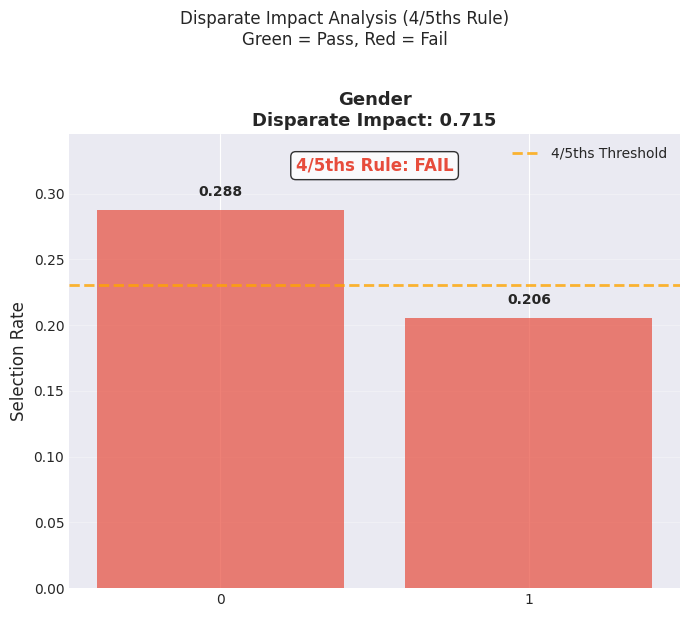

In [63]:
# Visualize Disparate Impact
n_attrs = len(disparate_impact_results)
if n_attrs > 0:
    fig, axes = plt.subplots(1, n_attrs, figsize=(7*n_attrs, 6))
    if n_attrs == 1:
        axes = [axes]
    
    for idx, (attr, results) in enumerate(disparate_impact_results.items()):
        group_rates = results['group_rates']
        di_ratio = results['di_ratio']
        
        colors = ['#e74c3c' if not results['passes_4_5_rule'] else '#2ecc71' 
                  for _ in range(len(group_rates))]
        
        axes[idx].bar(range(len(group_rates)), group_rates['selection_rate'], 
                      color=colors, alpha=0.7)
        axes[idx].set_xticks(range(len(group_rates)))
        axes[idx].set_xticklabels(group_rates.index)
        axes[idx].set_ylabel('Selection Rate', fontsize=12)
        axes[idx].set_title(f'{sensitive_attrs[attr]}\nDisparate Impact: {di_ratio:.3f}', 
                           fontsize=13, fontweight='bold')
        axes[idx].set_ylim([0, max(group_rates['selection_rate']) * 1.2])
        axes[idx].grid(axis='y', alpha=0.3)
        
        # Add 4/5ths threshold line
        threshold_val = group_rates['selection_rate'].max() * 0.8
        axes[idx].axhline(y=threshold_val, color='orange', linestyle='--', 
                         linewidth=2, label='4/5ths Threshold', alpha=0.8)
        axes[idx].legend()
        
        # Add value labels
        for i, v in enumerate(group_rates['selection_rate']):
            axes[idx].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
        
        # Add pass/fail indicator
        status = "PASS" if results['passes_4_5_rule'] else "FAIL"
        status_color = '#2ecc71' if results['passes_4_5_rule'] else '#e74c3c'
        axes[idx].text(0.5, 0.95, f'4/5ths Rule: {status}', 
                      transform=axes[idx].transAxes, ha='center', va='top',
                      fontsize=12, fontweight='bold', color=status_color,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Disparate Impact Analysis (4/5ths Rule)\nGreen = Pass, Red = Fail', 
                 fontsize=12, y=1.02)
    plt.tight_layout()
    plt.savefig('../figures/fairness/disparate_impact.png', dpi=300, bbox_inches='tight')
    plt.show()